In [1]:
import dm_den
import dm_den_viz
import pickle
import paths
import numpy as np
import pandas as pd
import scipy
import lmfit
import warnings
import os
import time
import copy
from IPython.display import Latex
from importlib import reload
from lmfit import minimize, Parameters
from importlib import reload
from progressbar import ProgressBar
from SHMpp import SHMpp_gvmin_reconcile as shmpp

import fitting
from fitting import smooth_step_max

from astropy import units as u

import scipy
#from scipy.stats.stats import pearsonr
from scipy import integrate

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import rcParams

rcParams['axes.labelsize']=15.
rcParams['xtick.labelsize'] = 12.
rcParams['ytick.labelsize'] = 12.
rcParams['figure.dpi'] = 150.

In [3]:
sigmoid_damped_eqnum = 5.7
mao_eqnum = 2.7

# Cautionary note  
Please note that as of now, in some places of the following code I accidentally say $f(v)$ when I mean $p(v)$. $p(v)=f(v)\,4\pi v^2$. I didn't realize this until recently, and I haven't yet gone through and corrected the variable names. Whenever you see $f(v)$, please use context to check whether I meant $f(v)$ or $p(v)$.


# Getting started

## Loading data

In [4]:
with open('./data/v_pdfs.pkl','rb') as f:
    pdfs_v=pickle.load(f)
with open('./data/v_counts_disc_dz1.0.pkl', 'rb') as f:
    counts_v = pickle.load(f)
with open('./data/v_pdfs_disc_dz1.0.pkl', 'rb') as f:
    pdfs_disc = pickle.load(f)
vs_pdfs=np.array([pdfs_v[galname]['bins'] 
                  for galname in pdfs_v]).flatten()
vs_shm=np.linspace(vs_pdfs.min(), vs_pdfs.max(), 70)
with open('./data/vescs_rot_20230514.pkl', 'rb') as f:
    vesc_dict = pickle.load(f)
with open('./data/v_pdfs_incl_ve_20220205.pkl','rb') as f:
    pdfs_v_incl_vearth=pickle.load(f)
with open(paths.data + 'data_raw.pkl', 'rb') as f:
    results_dict = pickle.load(f)

# Individual halo integral fits
Part of my reason for inspecting this was to see, if I fit based on the halo integral directly as opposed to the speed distribution, could I get the Maxwellian fit to match the FIRE halo integral data as closely as others have matched the data in their simulations. The "best case" Maxwellian ends up not looking great, so I also check in Earth's reference frame. That doesn't look great either.  

However, I think the problem may have been that in this section I was fitting in the linear regime of the halo integral. In order to get a good fit in the tail it's probably necessary to perform the fit in log space. However, I've moved on from trying to see how good the Maxwellian can get in the best possible scenario. Others don't fit the halo integral anyway; they fit the speed distribution.

That said, I *do* explore performing a universal halo integral fit in log space further below, but I do that for the sigmoid-damped model (`smooth_step_max`), not the Maxwellian.

100% |###################################################################################################################################################################################################|


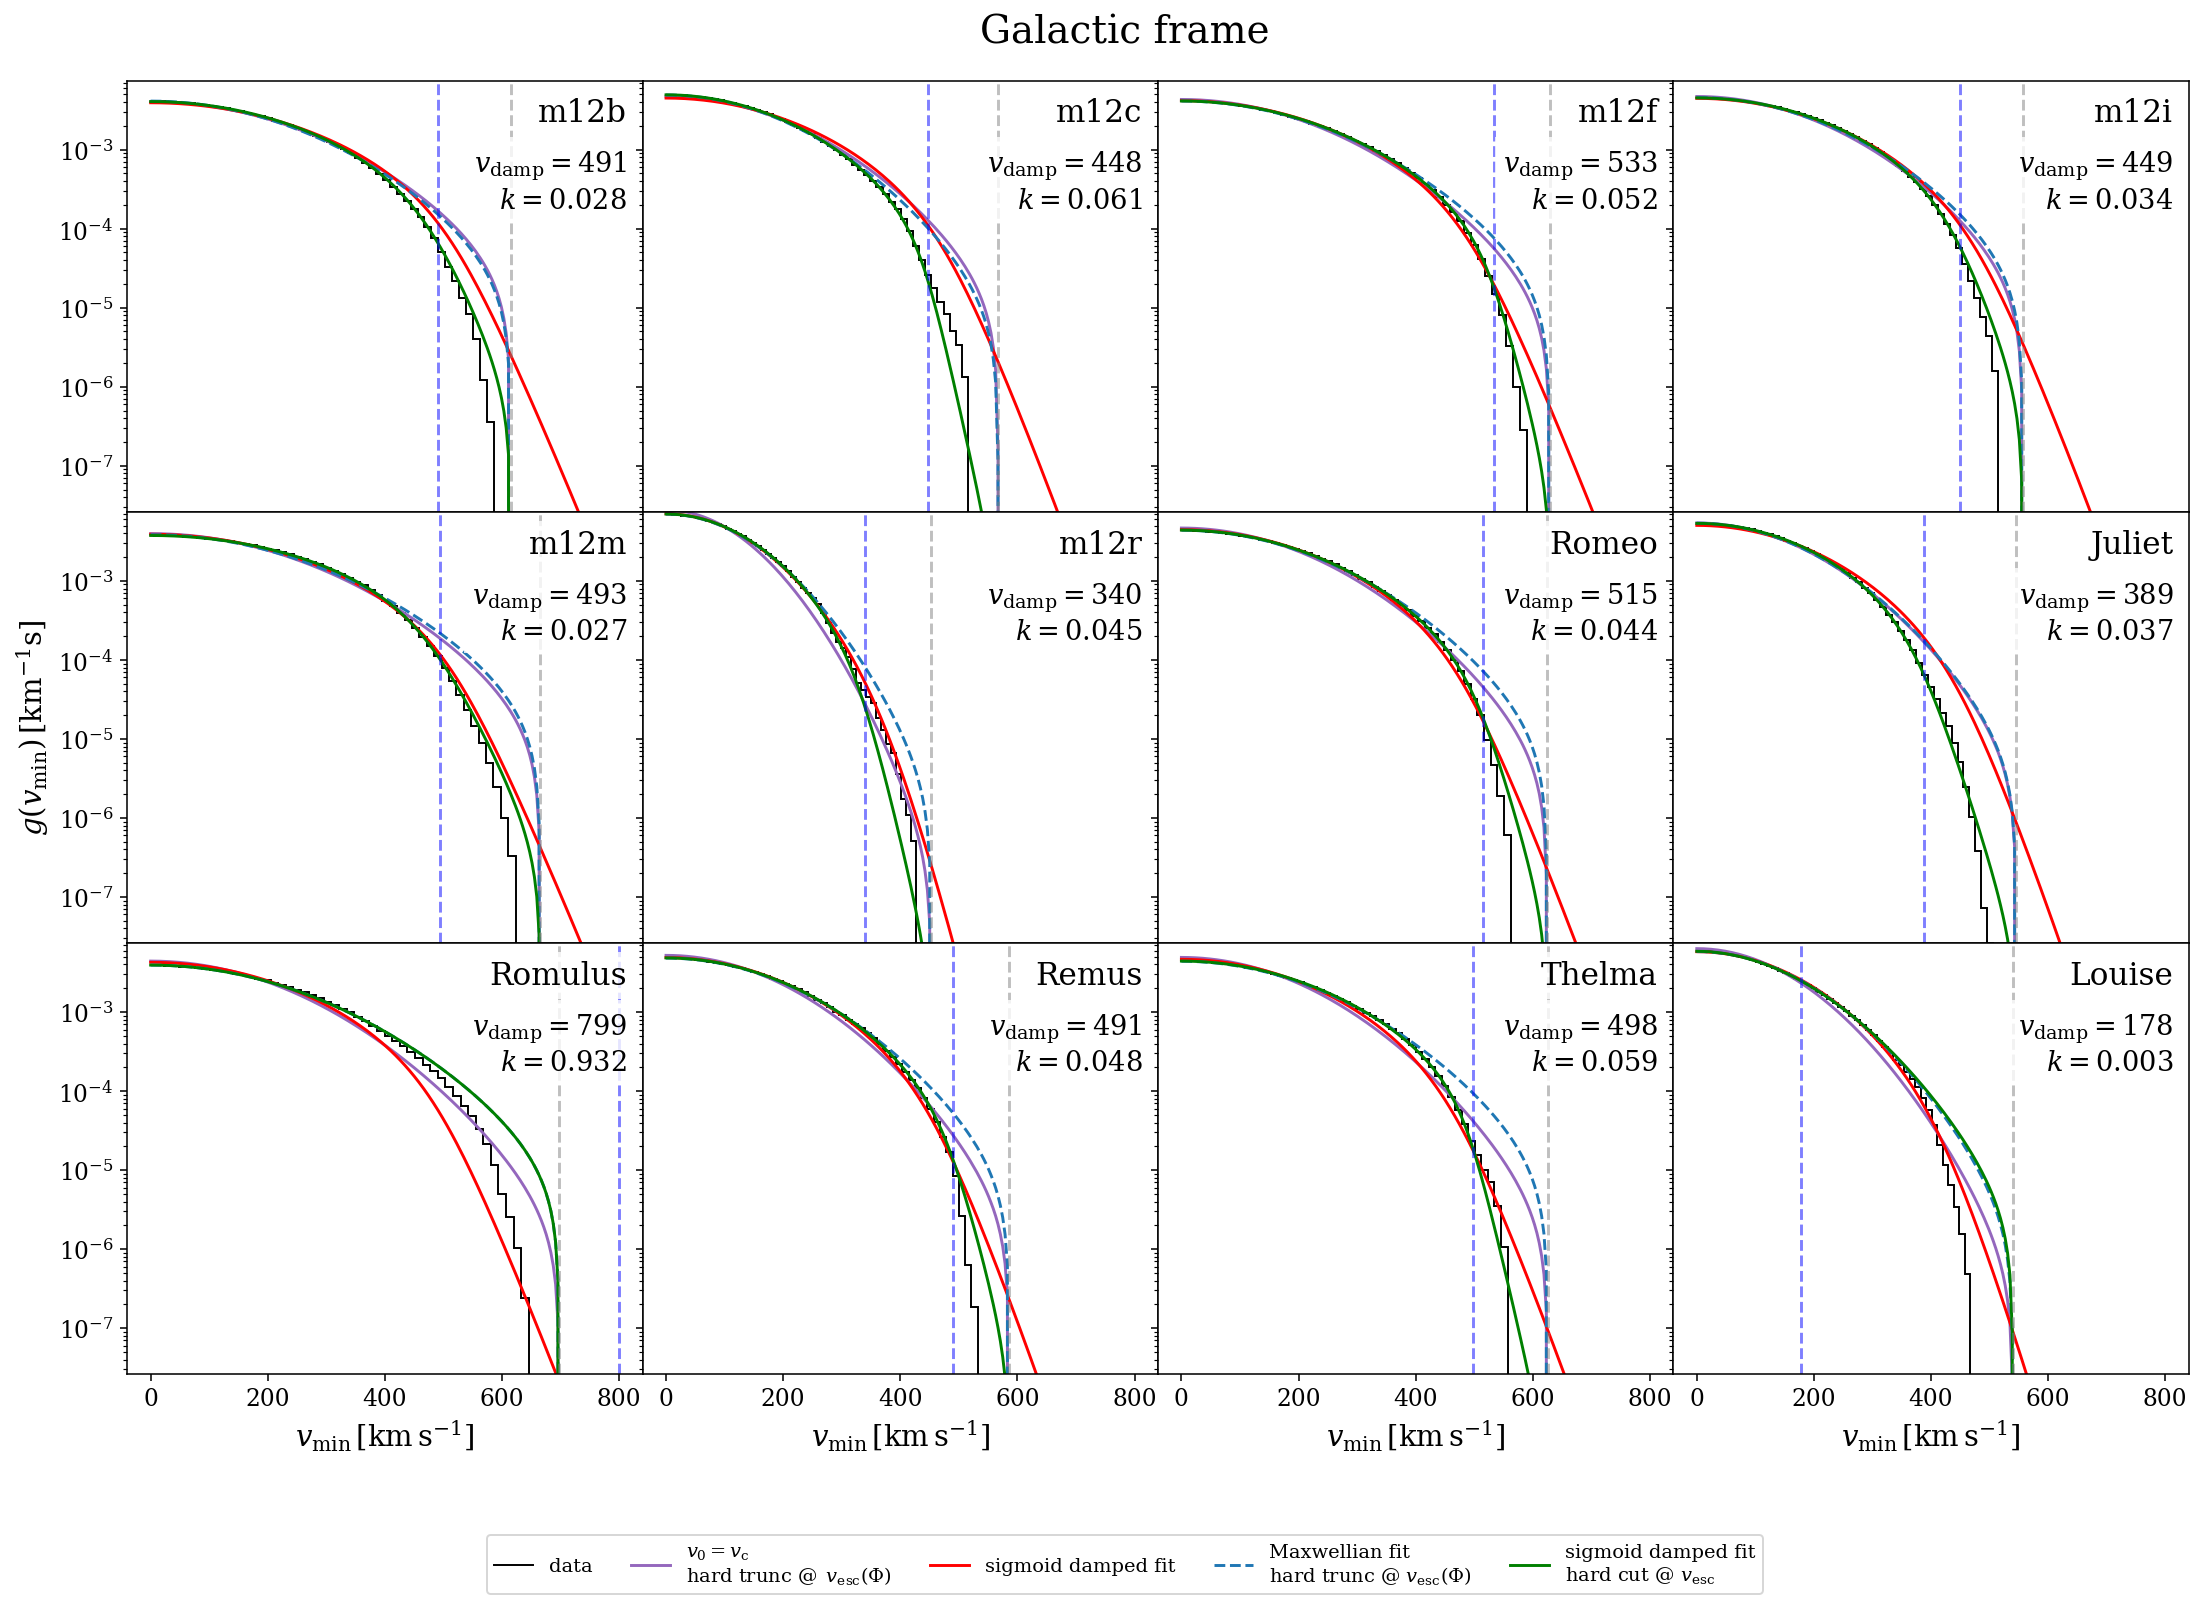

In [5]:
reload(fitting)
def plot_g_indv():
    df = dm_den.load_data('dm_stats_20221208.h5')
    pdfs = pdfs_disc.copy()
    pdfs.pop('m12z')
    pdfs.pop('m12w')
    
    fig,axs=plt.subplots(3,4,figsize=(19., 12.), sharex=True, sharey=True,
                         dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    ymin = np.inf
    
    pbar = ProgressBar()
    for i, gal in enumerate(pbar(pdfs.keys())):
        dict_gal = pdfs[gal]
        vs_truth = dict_gal['vs']
        ps_truth = dict_gal['ps']
        counts = counts_v[gal]['counts']
        vc = df.loc[gal, 'v_dot_phihat_disc(T<=1e4)']
        vc_forfit = np.repeat(vc, len(vs_truth)).astype(np.float64)
        vesc = vesc_dict[gal]['ve_avg']
        vesc_forfit = np.repeat(vesc, len(vs_truth)).astype(np.float64)
        
        ########################################################################
        # Plot the data
        ########################################################################
        '''
        Calculation method for g:
            p(vmin) = 4pi v^2 f(v)
            g(vmin) = int f(v)/v (4pi v^2 dv) 
                     = int p(v) / (4pi v^2) v^2/v 4pi dv
                     = int p(v)/v dv
        '''
        integrand_truth = ps_truth / vs_truth
        gs_truth = [scipy.integrate.simps(integrand_truth[i:], vs_truth[i:]) 
                    for i in range(len(integrand_truth))]
        gs_truth = np.array(gs_truth)        
        ymin = np.min([ymin, np.min(gs_truth[gs_truth > 0.])])
        axs[i].stairs(gs_truth, dict_gal['bins'], color='k', label='data',
                      baseline=None)
        
        vs_hat = np.linspace(0., 800., 200)
        
        ########################################################################
        # Plot g for v0 = vc, sharp cutoff at vesc(Phi)
        ########################################################################       
        gs_vc = fitting.g_smooth_step_max(vs_hat, vc, vesc, np.inf)
        axs[i].plot(vs_hat, gs_vc, 
                    label = '$v_0 = v_\mathrm{{c}}$'\
                            '\n'\
                            'hard trunc @ $\,v_\mathrm{{esc}}(\Phi)$',
                    c='C4')
        
        ########################################################################
        # Plot g for our prediction from vc
        ########################################################################     
        d, e, h, j, k = [results_dict[var] for var in ['d', 'e', 'h', 'j', 'k']]
        axs[i].plot(vs_hat,
                    fitting.g_smooth_step_max(
                                   vs_hat, 
                                   d * (vc / 100.) ** e,
                                   h * (vc / 100.) ** j,
                                   k),
                    color='red',
                    label='sigmoid damped fit')
        
        '''
        ########################################################################
        # Plot g for best fit p based on `exp_max`
        ########################################################################   
        model_exp = lmfit.Model(fitting.exp_max, independent_vars=['v','vesc'])
        params_exp = model_exp.make_params()
        params_exp['v0'].set(value=230., vary=True, min=100., max=400.)
        exp_result = model_exp.fit(ps_truth, params_exp, v=vs_truth, vesc=vesc,
                                   method='nelder')
        #display(exp_result)
        #print('{0:s}: v0 = {1:0.0f}'.format(gal, exp_result.params['v0'].value))
        axs[i].plot(vs_hat,
                    fitting.g_exp(vs_hat, 
                                  exp_result.params['v0'].value,
                                  vesc),
                    label='fit\n'
                          'exp trunc @ $v_\mathrm{esc}(\Phi)$', ls='--')
        
        ########################################################################
        # Plot g for best fit p based on `exp_max`, fitting both v0 and vdamp
        ########################################################################
        model_exp_damp = lmfit.Model(fitting.exp_max)
        params_exp_damp = model_exp_damp.make_params()
        params_exp_damp['v0'].set(value=230., vary=True, min=100., max=400.)
        params_exp_damp['vesc'].set(value=450., vary=True, min=230., max=900.)
        exp_damp_result = model_exp_damp.fit(ps_truth, params_exp_damp,
                                             v=vs_truth, method='nelder')
        axs[i].plot(vs_hat,
                    fitting.g_exp(vs_hat,
                                  exp_damp_result.params['v0'].value,
                                  exp_damp_result.params['vesc'].value),
                    label='fit\n'
                          'exp trunc @ $v_\mathrm{damp}$')                          
        '''
        
        ########################################################################
        # Plot g for best fit p based on a simple Maxwellian with a hard
        # truncation at vesc
        ########################################################################  
        model_hard = lmfit.Model(fitting.smooth_step_max, 
                                 independent_vars=['v', 'vdamp', 'k'])
        params_hard = model_hard.make_params()
        params_hard['v0'].set(value=vc, vary=True, min=100., max=400.)
        hard_result = model_hard.fit(ps_truth, params_hard, v=vs_truth, 
                                     vdamp=vesc, k=np.inf,
                                     method='nelder')
        axs[i].plot(vs_hat,
                    fitting.g_smooth_step_max(vs_hat, 
                                              hard_result.params['v0'].value, 
                                              vesc, np.inf), 
                    label='Maxwellian fit\n'
                          'hard trunc @ $v_\mathrm{esc}(\Phi)$', ls='--')
        
        ########################################################################
        # Plot g for best fit p based on a damped and truncated Maxwellian 
        # (`max_double_hard`)
        ######################################################################## 
        model_dbl = lmfit.Model(fitting.max_double_hard, 
                                 independent_vars=['v', 'vesc'])
        params_dbl = model_dbl.make_params()
        params_dbl['v0'].set(value=vc, vary=True, min=100., max=400.)
        params_dbl['vdamp'].set(value=450., vary=True, min=vc, max=800.)
        params_dbl['k'].set(value=0.03, vary=True, min=0.001, max=1.)
        result_dbl = model_dbl.fit(ps_truth, params_dbl, v=vs_truth, 
                                     vesc=vesc,
                                     method='nelder')
        axs[i].plot(vs_hat,
                    fitting.calc_g_general(vs_hat, 
                                           fitting.pN_max_double_hard,
                                           (result_dbl.params['v0'].value,
                                            result_dbl.params['vdamp'].value,
                                            result_dbl.params['k'].value,
                                            vesc)),
                    label='sigmoid damped fit\nhard cut @ $v_\mathrm{esc}$', 
                    ls='-',
                    color='green')
        
        '''
        ########################################################################
        # Plot g for our new prediction from vc
        ########################################################################         
        indv_fit_result = fitting.fit_g(galaxy=gal, parallel=False)
        d, e, h, j, k = [indv_fit_result.params[p].value for p in ['d', 'e', 
                                                                   'h', 'j', 
                                                                   'k']]
        vdamp_indv = h * (vc / 100.) ** j
        axs[i].plot(vs_hat,
                    fitting.g_smooth_step_max(
                        vs_hat, 
                        d * (vc / 100.) ** e,
                        h * (vc / 100.) ** j,
                        k),
                    #color='red',
                    label='new prediction from $v_\mathrm{c}$')
        del d, e, h, j, k
        '''
        
        # Draw vesc and vdamp lines
        axs[i].axvline(vesc, ls='--', alpha=0.5, color='grey')
        axs[i].axvline(result_dbl.params['vdamp'].value, ls='--', alpha=0.5, 
                       color='blue')
        
        loc=[0.97,0.96]
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                      va='top', ha='right', 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(gal,loc,
                        **kwargs_txt)
        loc[1] -= 0.12
        kwargs_txt['fontsize'] = 14
        axs[i].annotate('$v_\mathrm{{damp}}={0:0.0f}$\n'
                        #'$v_\mathrm{esc}={1:0.0f}$\n'
                        '$k={1:0.3f}$'.format(*[result_dbl.params[p].value
                                                for p in ['vdamp',
                                                          'k']]),
                        loc, **kwargs_txt)
        #axs[i].set_ylim(1e-9, 0.0075)
        axs[i].set_ylim(ymin, 0.0075)
        #axs[i].set_ylim(1.e-6, 8.e-3)
        axs[i].grid(False)
        axs[i].set_yscale('log')
    for i in [4]:
        axs[i].set_ylabel(
            '$g(v_\mathrm{min})\,\left[\mathrm{km^{-1}s}\\right]$')
    for ax in axs[-4:]:
        ax.set_xlabel('$v_\mathrm{min}\,\left[\mathrm{km\,s^{-1}}\\right]$')
    axs[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0.02),
                   bbox_transform=fig.transFigure, ncol=5)
    fig.suptitle('Galactic frame', fontsize=20., y=0.92)
    plt.show()

    return None
plot_g_indv()

## Trying to adjust for $v_\oplus$
To see if I can get the Maxwellian can get as close to the halo integral data in FIRE as others have in their simulations

100% |###################################################################################################################################################################################################|


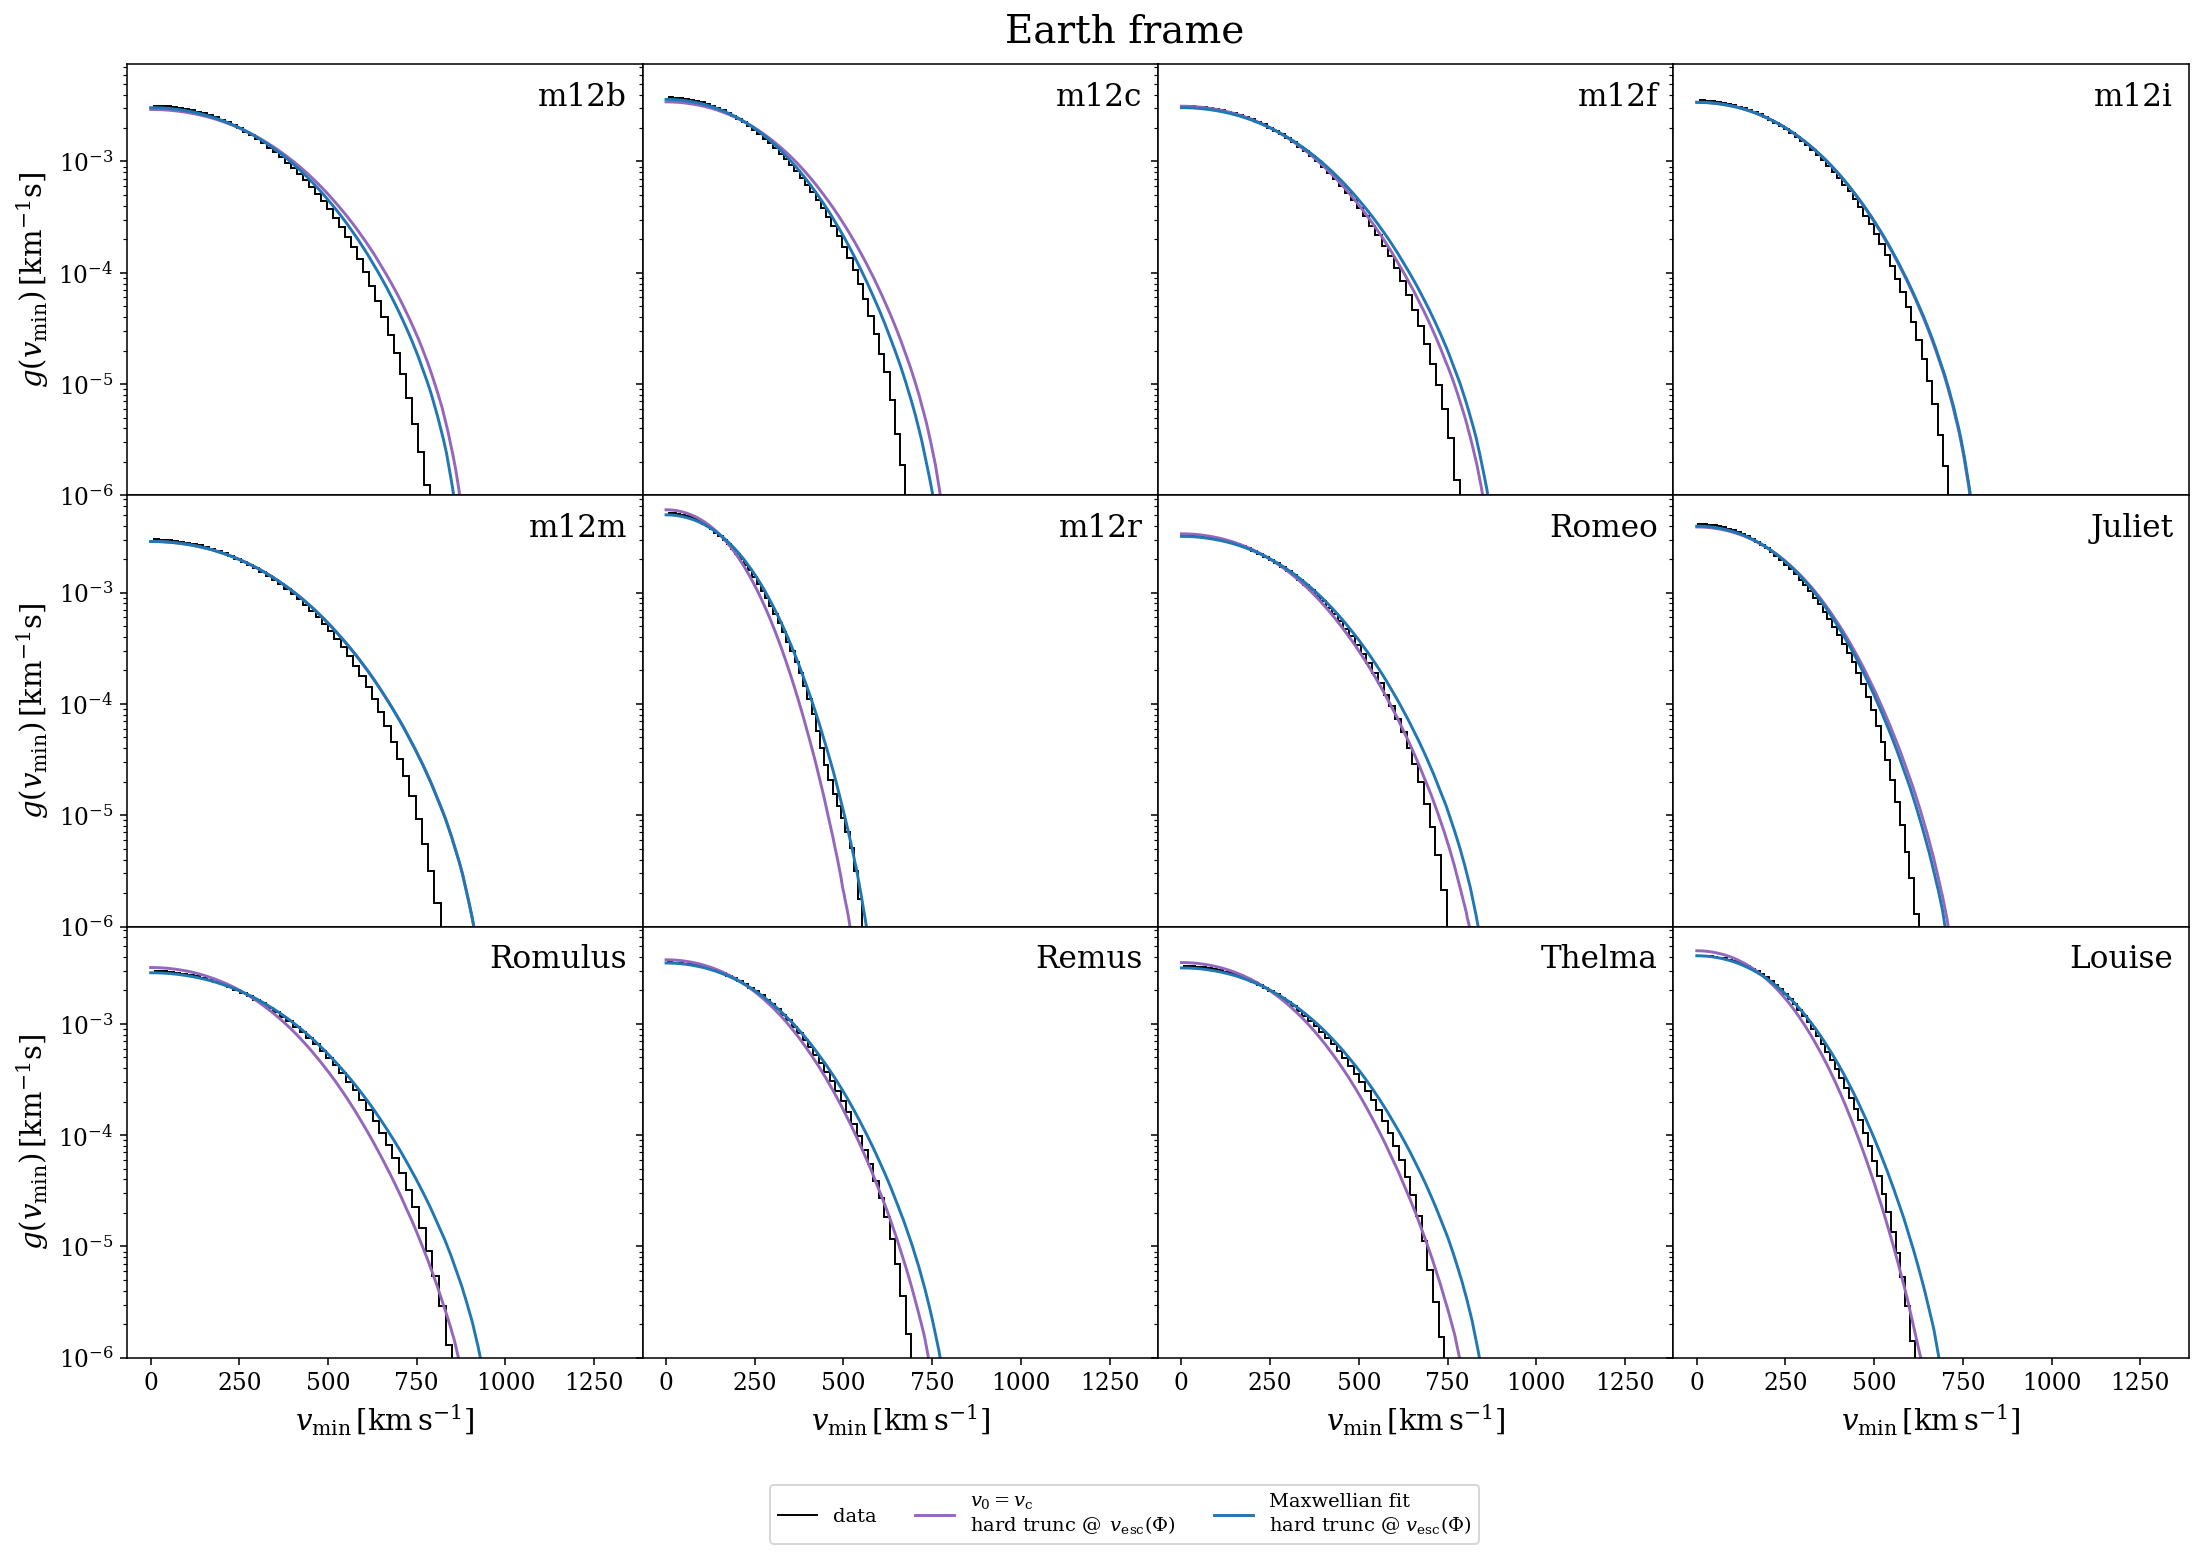

In [6]:
reload(fitting)
reload(shmpp)
def plot_g_indv():
    df = dm_den.load_data('dm_stats_20221208.h5')
    pdfs = pdfs_v.copy()
    pdfs.pop('m12z')
    pdfs.pop('m12w')
    
    fig,axs=plt.subplots(3,4,figsize=(19.,12.), sharex=True, sharey=True,
                         dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    ymin = np.inf
    
    pbar = ProgressBar()
    for i, gal in enumerate(pbar(pdfs)):
        dict_gal = pdfs[gal]
        vs_truth = dict_gal['vs']
        ps_truth = dict_gal['ps']
        ps_truth_incl_vearth = pdfs_v_incl_vearth[gal]['ps']
        bins_incl_vearth = pdfs_v_incl_vearth[gal]['bins']
        vs_truth_incl_vearth = (bins_incl_vearth[1:] + bins_incl_vearth[:-1])/2.
        vc = df.loc[gal, 'v_dot_phihat_disc(T<=1e4)']
        vc_forfit = np.repeat(vc, len(vs_truth)).astype(np.float64)
        vesc = vesc_dict[gal]['ve_avg']
        vesc_forfit = np.repeat(vesc, len(vs_truth)).astype(np.float64)
        sigma_truth = df.loc[gal, 'disp_dm_disc_cyl']
        
        X = [vs_truth, vc, vesc]
        
        ########################################################################
        # Plot the data
        ########################################################################
        '''
        Calculation method for g:
            p(vmin) = 4pi v^2 f(v)
            g(vmin) = int f(v)/v (4pi v^2 dv) 
                     = int p(v) / (4pi v^2) v^2/v 4pi dv
                     = int p(v)/v dv
        '''
        integrand_truth = ps_truth_incl_vearth / vs_truth_incl_vearth
        gs_truth = [scipy.integrate.simps(integrand_truth[i:], 
                                          vs_truth_incl_vearth[i:]) 
                    for i in range(len(integrand_truth))]
        gs_truth = np.array(gs_truth)        
        ymin = np.min([ymin, np.min(gs_truth[gs_truth > 0.])])
        #axs[i].plot(vs_truth, gs_truth, c='k', 
        #            label='data')
        axs[i].stairs(gs_truth, pdfs_v_incl_vearth[gal]['bins'], color='k', 
                      label='data', baseline=None)

        vs_hat = np.linspace(0., 800., 200)
        
        ########################################################################
        # Plot g for v0 = vc, sharp cutoff at vesc(Phi)
        ########################################################################       
        vs_vc, gs_vc = shmpp.gen_round(vc, vesc, verbose=False)
        axs[i].plot(vs_vc, gs_vc, 
                    label = '$v_0 = v_\mathrm{{c}}$'\
                            '\n'\
                            'hard trunc @ $\,v_\mathrm{{esc}}(\Phi)$',
                    c='C4')
        
        '''
        ########################################################################
        # Plot g for our prediction from vc
        ########################################################################     
        d, e, h, j, k = [results_dict[var] for var in ['d', 'e', 'h', 'j', 'k']]
        axs[i].plot(vs_hat,
                    fitting.g_smooth_step_max(
                                   vs_hat, 
                                   d * (vc / 100.) ** e,
                                   h * (vc / 100.) ** j,
                                   k),
                    color='red',
                    label='prediction from $v_\mathrm{c}$')
        
        ########################################################################
        # Plot g for best fit p based on `exp_max`
        ########################################################################   
        model_exp = lmfit.Model(fitting.exp_max, independent_vars=['v','vesc'])
        params_exp = model_exp.make_params()
        params_exp['v0'].set(value=230., vary=True, min=100., max=400.)
        exp_result = model_exp.fit(ps_truth, params_exp, v=vs_truth, vesc=vesc,
                                   method='nelder')
        #display(exp_result)
        #print('{0:s}: v0 = {1:0.0f}'.format(gal, exp_result.params['v0'].value))
        axs[i].plot(vs_hat,
                    fitting.g_exp(vs_hat, 
                                  exp_result.params['v0'].value,
                                  vesc),
                    label='fit\n'
                          'exp trunc @ $v_\mathrm{esc}(\Phi)$')
        '''
        
        ########################################################################
        # Plot g for best fit p based on a simple Maxwellian with a hard
        # truncation at vesc
        ########################################################################  
        model_hard = lmfit.Model(fitting.smooth_step_max, 
                                 independent_vars=['v', 'vdamp', 'k'])
        params_hard = model_hard.make_params()
        params_hard['v0'].set(value=vc, vary=True, min=100., max=400.)
        hard_result = model_hard.fit(ps_truth, params_hard, v=vs_truth, 
                                     vdamp=vesc, k=np.inf,
                                     method='nelder')
        vs_hard, gs_hard = shmpp.gen_round(hard_result.params['v0'].value, 
                                           vesc, verbose=False)
        axs[i].plot(vs_hard,
                    gs_hard,
                    label='Maxwellian fit'
                          '\nhard trunc @ $v_\mathrm{esc}(\Phi)$')
        
        '''
        ########################################################################
        # Plot g for our new prediction from vc
        ########################################################################         
        indv_fit_result = fitting.fit_g(galaxy=gal, parallel=False)
        d, e, h, j, k = [indv_fit_result.params[p].value for p in ['d', 'e', 
                                                                   'h', 'j', 
                                                                   'k']]
        vdamp_indv = h * (vc / 100.) ** j
        axs[i].plot(vs_hat,
                    fitting.g_smooth_step_max(
                        vs_hat, 
                        d * (vc / 100.) ** e,
                        h * (vc / 100.) ** j,
                        k),
                    #color='red',
                    label='new prediction from $v_\mathrm{c}$')
        del d, e, h, j, k

        
        # Draw vesc and vdamp lines
        axs[i].axvline(vesc, ls='--', alpha=0.5, color='grey')
        axs[i].axvline(vdamp_indv, ls='--', alpha=0.5, color='grey')
        '''
        
        loc=[0.97,0.96]
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                      va='top', ha='right', 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(gal,loc,
                        **kwargs_txt)
        axs[i].set_ylim(1e-6, 0.0075)
        #axs[i].set_ylim(ymin, 0.0075)
        axs[i].grid(False)
        axs[i].set_yscale('log')
    for i in [0,4,8]:
        axs[i].set_ylabel(
            '$g(v_\mathrm{min})\,\left[\mathrm{km^{-1}s}\\right]$')
    for ax in axs[-4:]:
        ax.set_xlabel('$v_\mathrm{min}\,\left[\mathrm{km\,s^{-1}}\\right]$')
    axs[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0.04),
                   bbox_transform=fig.transFigure, ncol=5)
    fig.suptitle('Earth frame', fontsize=20., y=0.91)
    plt.show()

    return None
plot_g_indv()

# Universal halo integral fit
Based on the **log** of the halo integral

In [7]:
reload(fitting)
#start_time = time.time()
#gfit_results = fitting.fit_g(galaxy='discs', limit=1.e-5,
#                             parallel=False, update_values=True)
#print('{0:0.3f}s when run in sequence'.format(time.time() - start_time))

<module 'fitting' from '/Users/patrick/sliding_into_dm_code/fitting.py'>

In [8]:
gfit_results = lmfit.minimizer.MinimizerResult()
with open(paths.data + 'data_raw_gfit.pkl', 'rb') as f:
     gfit_results.params = pickle.load(f)

100% |###################################################################################################################################################################################################|


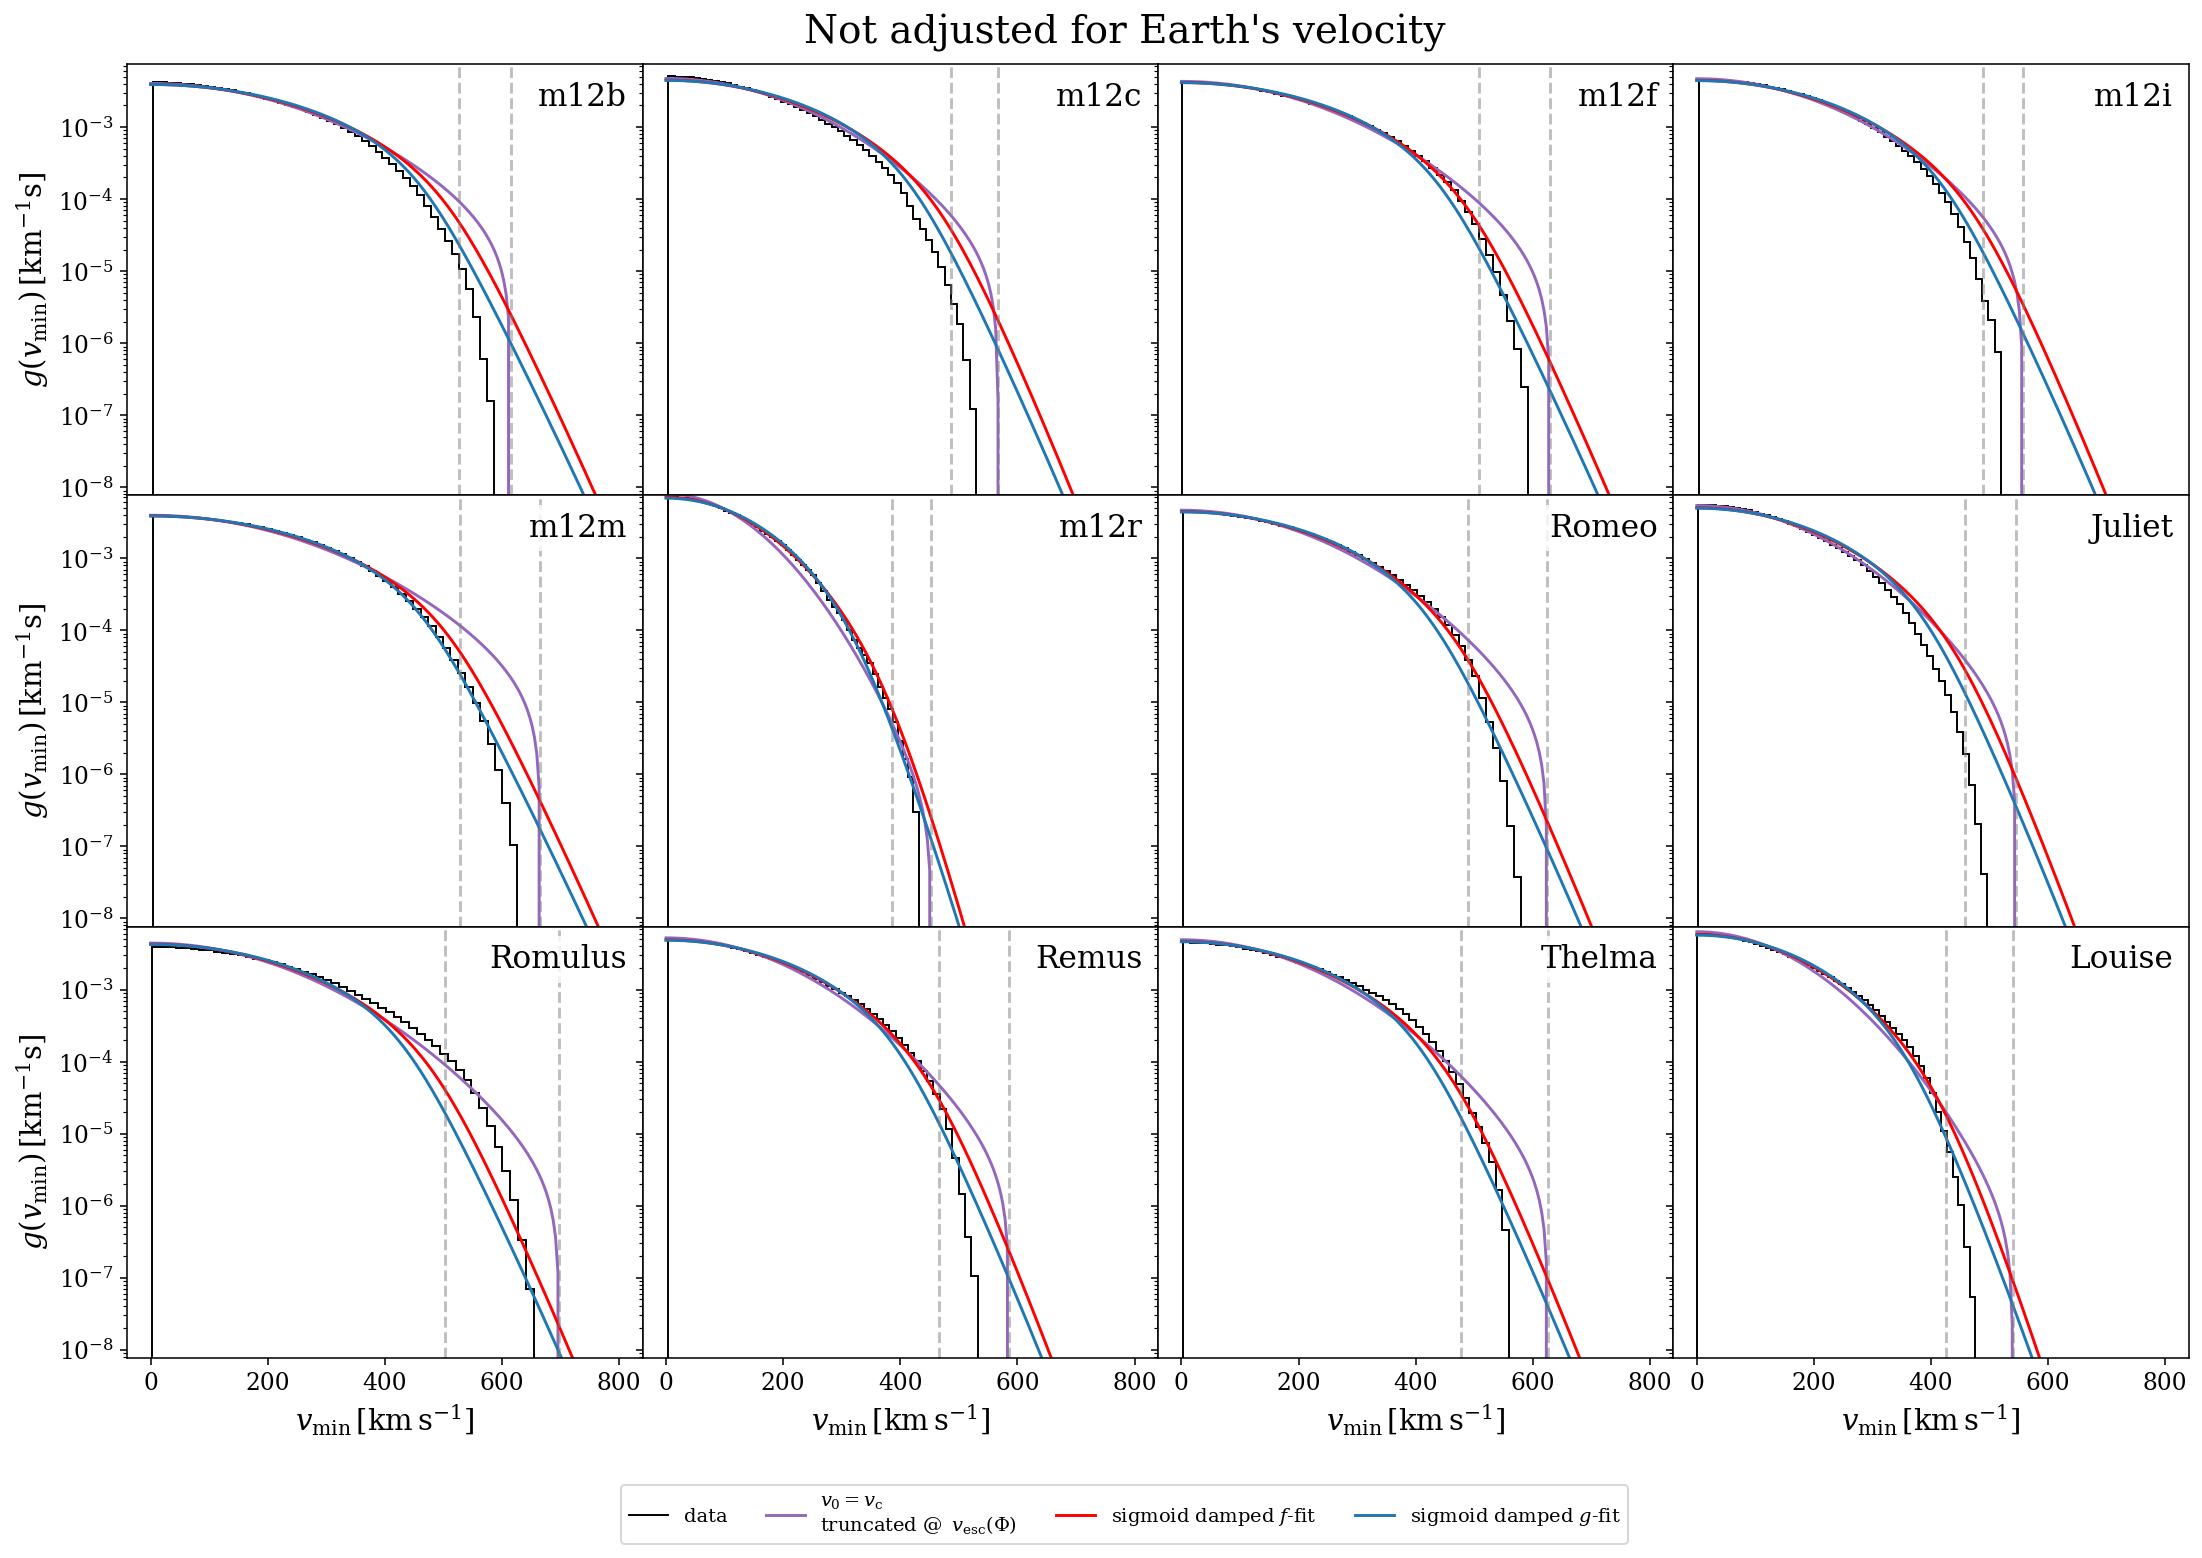

In [9]:
reload(fitting)
def plot_g_univ():
    df = dm_den.load_data('dm_stats_20221208.h5')
    pdfs = pdfs_v.copy()
    pdfs.pop('m12z')
    pdfs.pop('m12w')
    
    fig,axs=plt.subplots(3,4,figsize=(19.,12.), sharex=True, sharey=True,
                         dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    ymin = np.inf
    
    pbar = ProgressBar()
    for i, gal in enumerate(pbar(pdfs)):
        dict_gal = pdfs[gal]
        vs_truth = dict_gal['vs']
        ps_truth = dict_gal['ps']
        vc = df.loc[gal, 'v_dot_phihat_disc(T<=1e4)']
        vc_forfit = np.repeat(vc, len(vs_truth)).astype(np.float64)
        vesc = vesc_dict[gal]['ve_avg']
        vesc_forfit = np.repeat(vesc, len(vs_truth)).astype(np.float64)
        sigma_truth = df.loc[gal, 'disp_dm_disc_cyl']
        
        X = [vs_truth, vc, vesc]
        
        ########################################################################
        # Plot the data
        ########################################################################
        '''
        Calculation method for g:
            p(vmin) = 4pi v^2 f(v)
            g(vmin) = int f(v)/v (4pi v^2 dv) 
                     = int p(v) / (4pi v^2) v^2/v 4pi dv
                     = int p(v)/v dv
        '''
        integrand_truth = ps_truth / vs_truth
        gs_truth = [scipy.integrate.simps(integrand_truth[i:], vs_truth[i:]) 
                    for i in range(len(integrand_truth))]
        gs_truth = np.array(gs_truth)        
        ymin = np.min([ymin, np.min(gs_truth[gs_truth > 0.])])
        #axs[i].plot(vs_truth, gs_truth, c='k', 
        #            label='data')
        axs[i].stairs(gs_truth, dict_gal['bins'], color='k', label='data')
        
        '''
        X = [vs_truth, vc_forfit, vesc_forfit]
        res_de, _ = scipy.optimize.curve_fit(trunc_max_d_e, X, ps_truth, 
                                             p0=[0.86, 1.])
        d, e = res_de
        v0_prediction_de = d*vc**e
        gs_prediction_de = g_trunc_max_simple(vs_truth, v0_prediction_de, vesc)
        axs[i].plot(vs_truth, gs_prediction_de, label='$v_0=dv_\mathrm{c}^e$')
        '''

        vs_hat = np.linspace(0., 800., 200)
        
        ########################################################################
        # Plot g for v0 = vc, sharp cutoff at vesc(Phi)
        ########################################################################       
        gs_vc = fitting.g_smooth_step_max(vs_hat, vc, vesc, np.inf)
        axs[i].plot(vs_hat, gs_vc, 
                    label = '$v_0 = v_\mathrm{{c}}$'\
                            '\n'\
                            'truncated @ $\,v_\mathrm{{esc}}(\Phi)$',
                    c='C4')

        ########################################################################
        # Plot g for the naive Maxwellian
        ########################################################################  
        #axs[i].plot(vs_hat,
        #            fitting.g_smooth_step_max(vs_hat, v0_jeans, np.inf, np.inf),
        #            label = '$v_0 = \sigma_\mathrm{{3D,meas}}$'\
        #                    '\nnot truncated')
        
        ########################################################################
        # Plot g for our prediction from vc
        ########################################################################     
        d, e, h, j, k = [results_dict[var] for var in ['d', 'e', 'h', 'j', 'k']]
        vdamp = h * (vc / 100.) ** j
        axs[i].plot(vs_hat,
                    fitting.g_smooth_step_max(
                                   vs_hat, 
                                   d * (vc / 100.) ** e,
                                   vdamp,
                                   k),
                    color='red',
                    label='sigmoid damped $f$-fit')
        ########################################################################
        # Plot g for our new prediction from vc
        ########################################################################    
        axs[i].plot(vs_hat,
                    fitting.g_smooth_step_max(
                        vs_hat, 
                        gfit_results.params['d'] \
                            * (vc / 100.) ** gfit_results.params['e'],
                        gfit_results.params['h'] \
                            * (vc / 100.) ** gfit_results.params['j'],
                        gfit_results.params['k']),
                    #color='red',
                    label='sigmoid damped $g$-fit')
        
        # Draw vesc and vdamp lines
        axs[i].axvline(vesc, ls='--', alpha=0.5, color='grey')
        axs[i].axvline(vdamp, ls='--', alpha=0.5, color='grey')
        
        loc=[0.97,0.96]
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                      va='top', ha='right', 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(gal,loc,
                        **kwargs_txt)
        axs[i].set_ylim(ymin, 0.0075)
        #axs[i].set_ylim(1.e-5, 0.0075)
        axs[i].grid(False)
        axs[i].set_yscale('log')
    for i in [0,4,8]:
        axs[i].set_ylabel(
            '$g(v_\mathrm{min})\,\left[\mathrm{km^{-1}s}\\right]$')
    for ax in axs[-4:]:
        ax.set_xlabel('$v_\mathrm{min}\,\left[\mathrm{km\,s^{-1}}\\right]$')
    axs[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0.04),
                   bbox_transform=fig.transFigure, ncol=4)
    fig.suptitle('Not adjusted for Earth\'s velocity', fontsize=20., y=0.91)
    plt.show()
    return None
plot_g_univ()

## Backing into $f(v)$
from fitting the log of the halo integral

100% |###################################################################################################################################################################################################|


Done plotting galaxies. Finalizing figure.


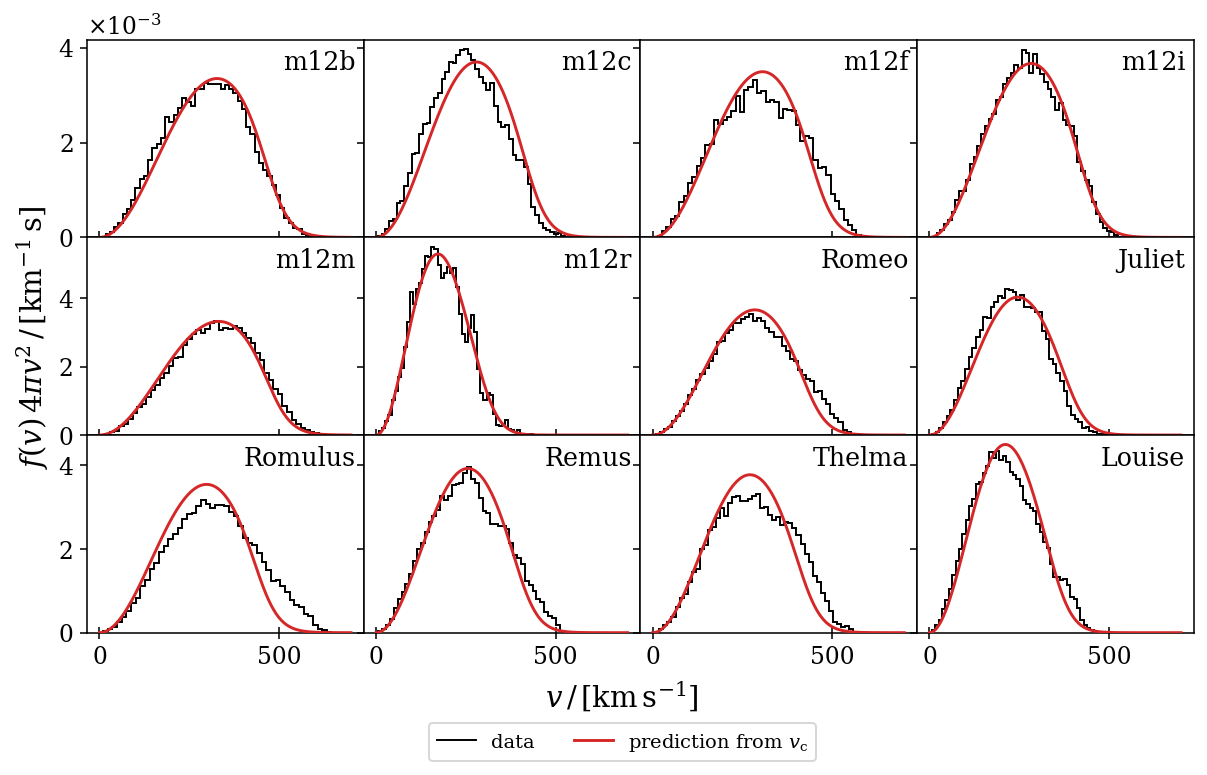

In [11]:
reload(dm_den_viz)
reload(fitting)
dm_den_viz.plt_universal_prefit(gfit_results, 
                                'dm_stats_dz1.0_20230724.h5',
                                show_bands=False)

# Halo integrals resulting from a universal fit on the speed distribution

100% |###################################################################################################################################################################################################|


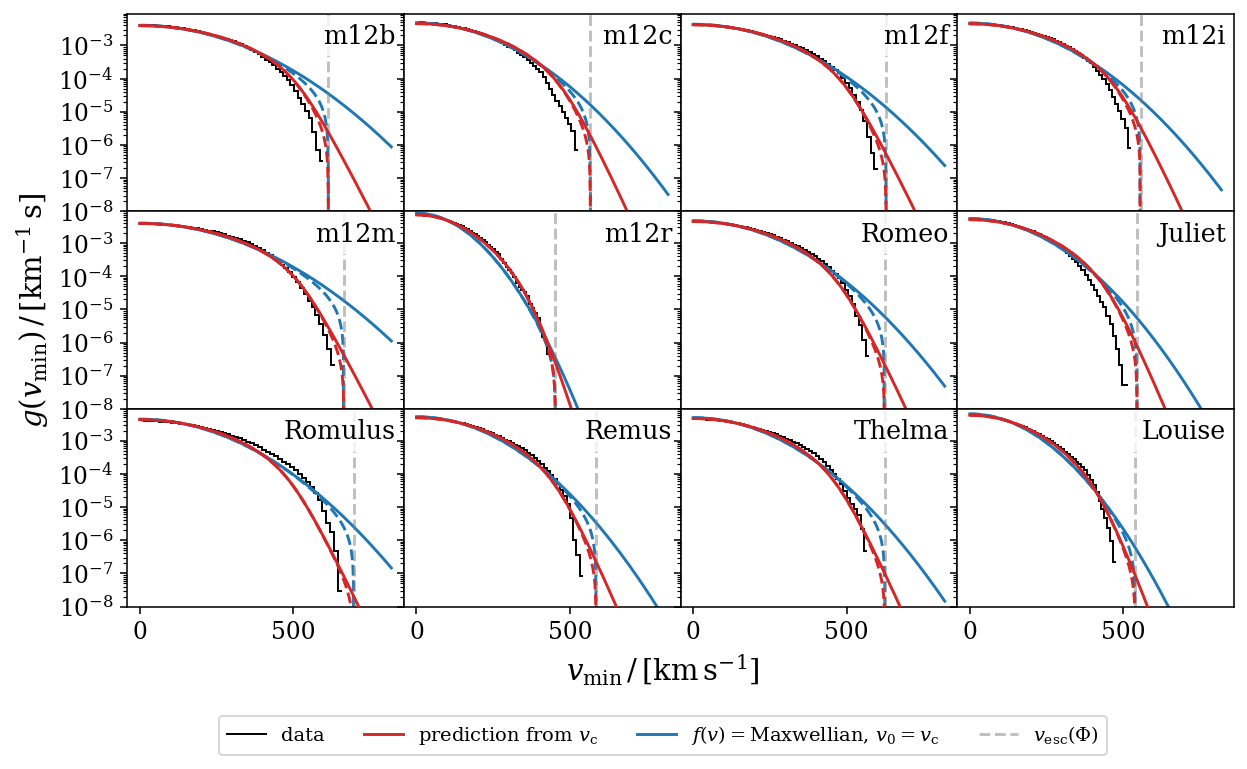

100% |###################################################################################################################################################################################################|


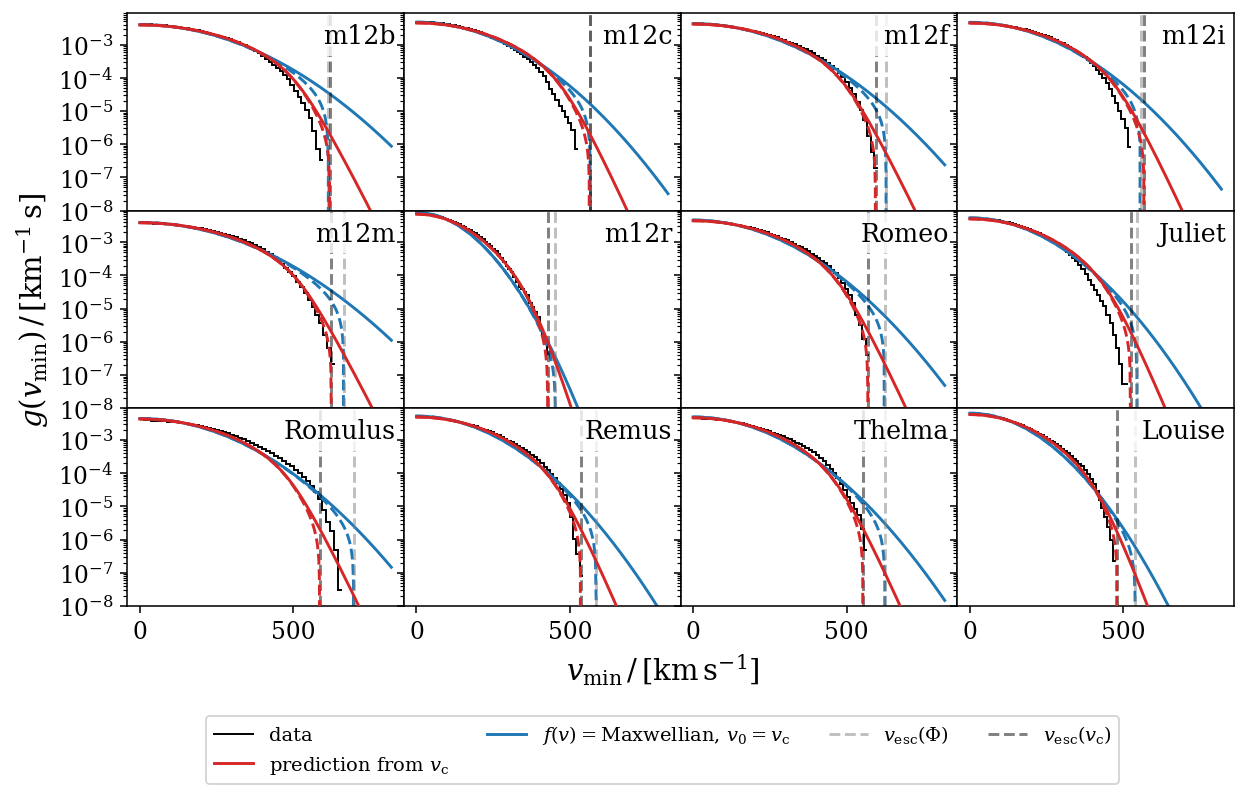

100% |###################################################################################################################################################################################################|


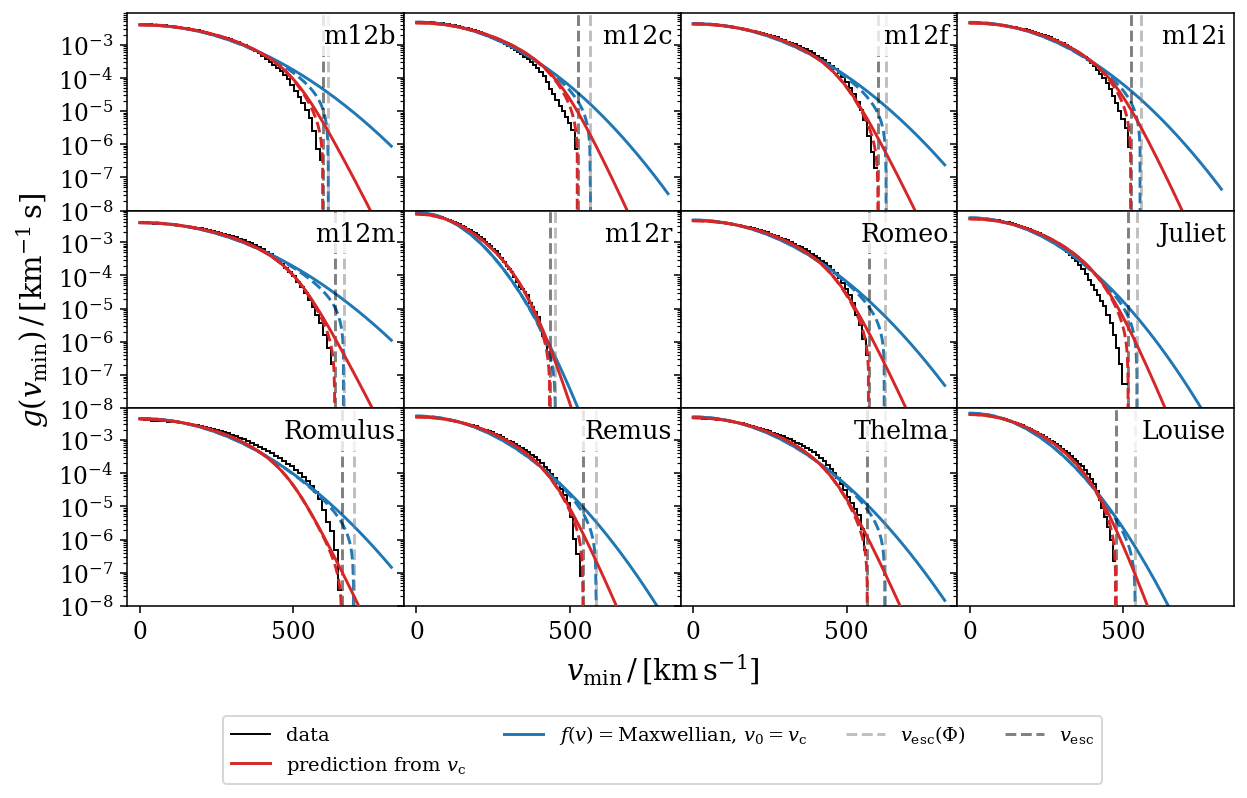

In [14]:
for vcut_type in ['veschatphi', 'lim_fit', 'lim']:
    dm_den_viz.plt_halo_integrals('discs', 
                                  'dm_stats_dz1.0_20230724.h5',
                                  std_vcut_type='veschatphi',
                                  prediction_vcut_type=vcut_type,
                                  show_max_exp=False, show_max_hard=True,
                                  show_sigmoid_exp=False, 
                                  show_sigmoid_hard=True,
                                  show_prediction_vcut=True, show_std_vcut=True,
                                  show_vcrit=False, ymin=1.e-8)

## Linear

100% |###################################################################################################################################################################################################|


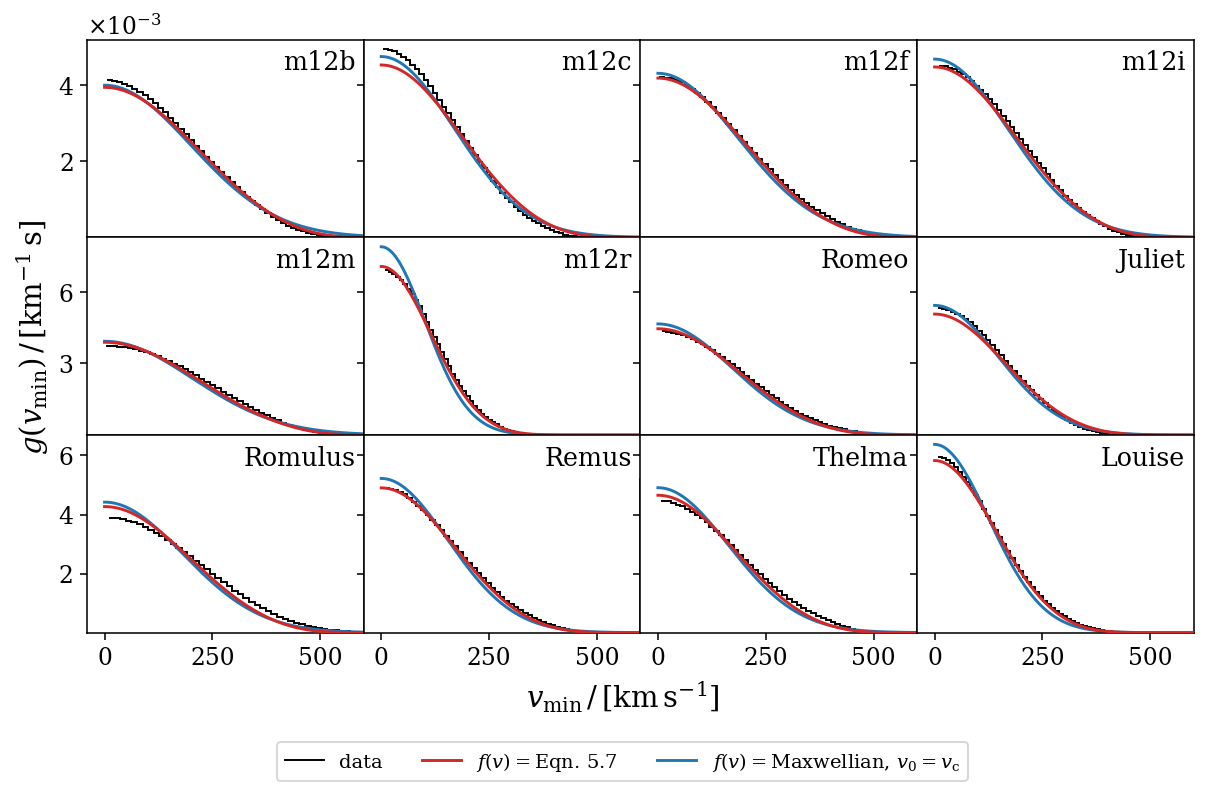

In [27]:
dm_den_viz.plt_halo_integrals('discs', 
                              df_source='dm_stats_dz1.0_20230724.h5',
                              scale='linear',
                              show_sigmoid_hard=False,
                              show_max_hard=False,
                              show_std_vcut=False, show_prediction_vcut=False,
                              xmax=600., xtickspace=250.,
                              #tgt_fname='halo_integrals_all.png',
                              sigmoid_damped_eqnum=sigmoid_damped_eqnum)

## Comparing to Mao
$f_\mathrm{Mao} \propto \exp\left(-\frac{|\vec{v}|}{v_0}\right)\left(v_\mathrm{esc}^2-\vec{v}^2\right)^p$  
$f_\mathrm{sigmoid} \propto \exp\left(-\frac{\vec{v}^2}{v_0^2}\right)\cdot S\left(v_\mathrm{damp}-|\vec{v}|\right)$  
$f_\mathrm{sigmoid,\,exp} = f_\mathrm{sigmoid}-\exp\left(\frac{v_\mathrm{esc}^2}{v_0^2}\right)\cdot S\left(v_\mathrm{damp}-|\vec{v}|\right)$

vcut type: lim_fit


100% |###################################################################################################################################################################################################|


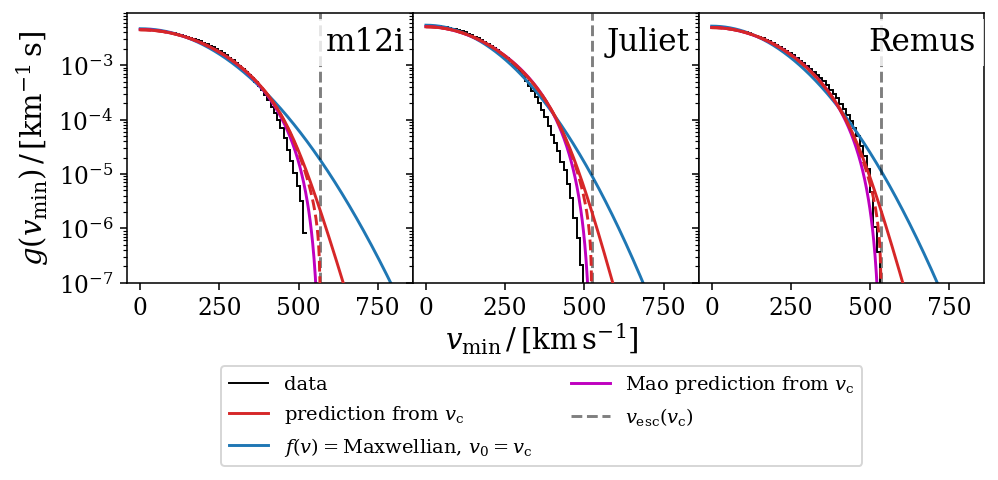

vcut type: veschatphi


100% |###################################################################################################################################################################################################|


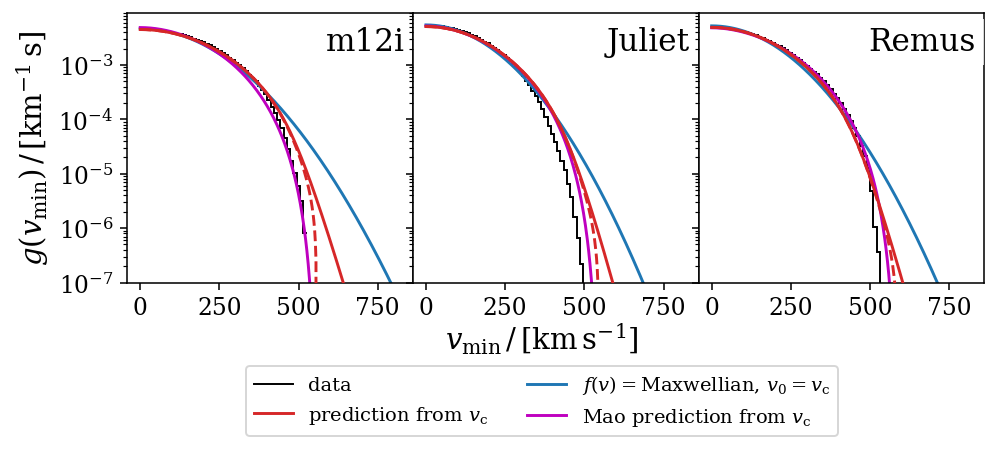

In [17]:
reload(dm_den_viz)
reload(fitting)
reload(dm_den)
for vcut_type in ['lim_fit', 'veschatphi']:
    print('vcut type: {0:s}'.format(vcut_type))
    dm_den_viz.plt_halo_integrals(['m12i', 'Juliet', 'Remus'],
                                  'dm_stats_dz1.0_20230724.h5',
                                  scale='log',
                                  show_sigmoid_exp=False,
                                  show_sigmoid_hard=True,
                                  show_mao_prediction=True, 
                                  show_mao_naive=False,
                                  show_max_hard=False,
                                  show_max_exp=False,
                                  prediction_vcut_type=vcut_type, 
                                  show_prediction_vcut=True,
                                  show_std_vcut=False,
                                  std_vcut_type='veschatphi',
                                  ymin=1.e-7)

100% |###################################################################################################################################################################################################|


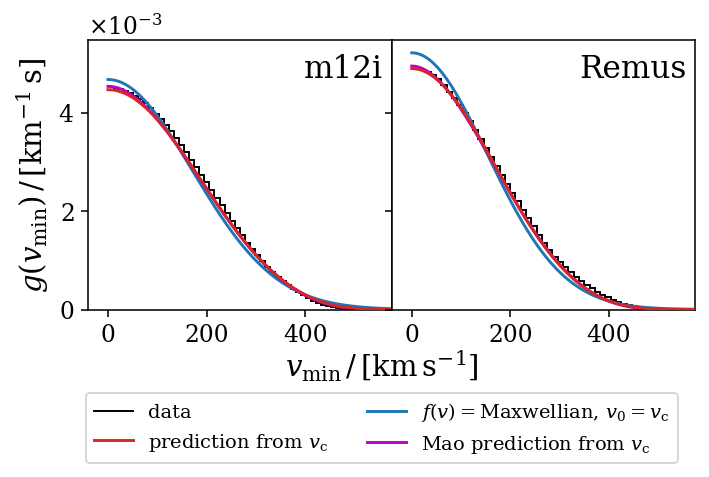

In [18]:
reload(dm_den_viz)
dm_den_viz.plt_halo_integrals(['m12i', 'Remus'],
                              df_source='dm_stats_dz1.0_20230724.h5',
                              scale='linear', 
                              ymax=None, ymin=0.,
                              xmax=575.,
                              show_max_hard=False,
                              show_max_exp=False,
                              show_sigmoid_exp=False,
                              show_sigmoid_hard=False,
                              show_mao_prediction=True, 
                              show_mao_naive=False,
                              std_vcut_type='veschatphi',
                              prediction_vcut_type='lim_fit',
                              show_prediction_vcut=False, show_std_vcut=False)

## Milky Way prediction

100% |###################################################################################################################################################################################################|


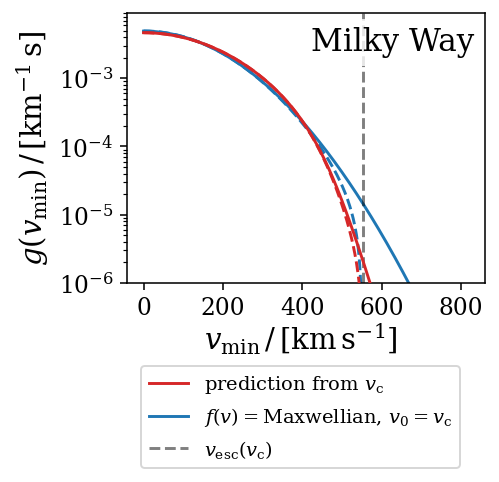

In [19]:
reload(dm_den_viz)
reload(fitting)
dm_den_viz.plt_halo_integrals(['mw'],
                              'dm_stats_dz1.0_20230724.h5',
                              prediction_vcut_type='lim_fit',
                              std_vcut_type='veschatphi',
                              show_sigmoid_exp=False,
                              show_sigmoid_hard=True,
                              show_prediction_vcut=True, 
                              show_max_hard=True,
                              show_max_exp=False, show_vcrit=False)

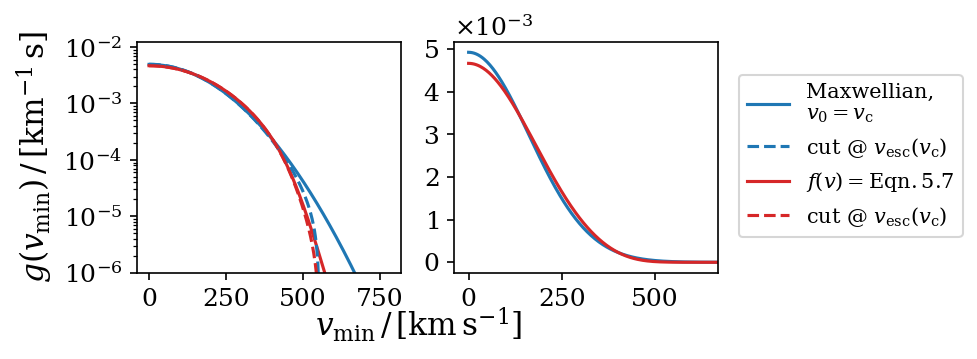

In [20]:
from importlib import reload
reload(dm_den_viz)
dm_den_viz.plt_halo_integral_mw('dm_stats_dz1.0_20230724.h5',  
                                xtickspace=250.,
                                sigmoid_damped_eqnum=sigmoid_damped_eqnum,)

/Users/patrick/sliding_into_dm_code/dm_den_viz.py:3360: RuntimeWarning: invalid value encountered in true_divide
  vmins, (gs_sigmoid_damped_hard / gs_max_hard),


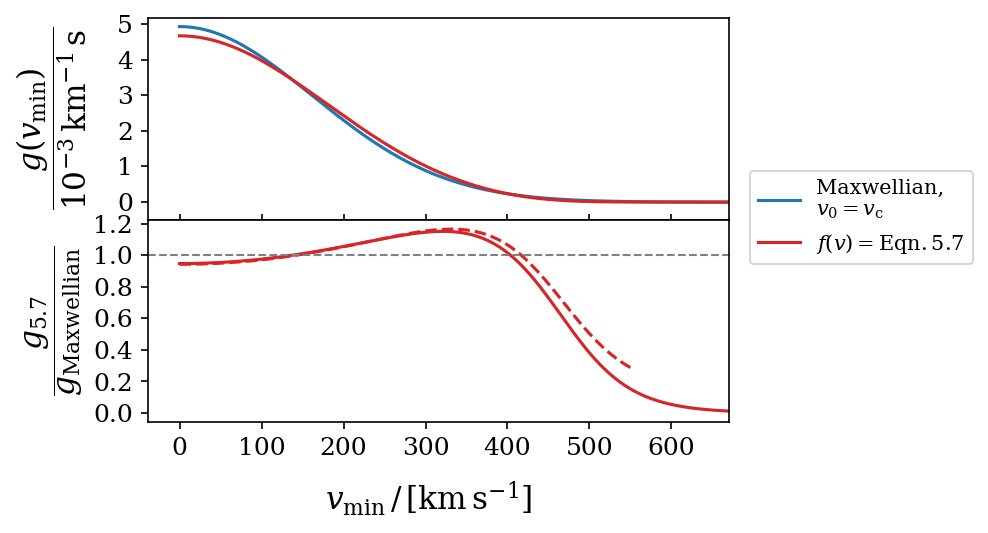

In [21]:
from importlib import reload
reload(dm_den_viz)
dm_den_viz.plt_halo_integral_mw_with_ratio(
    'dm_stats_dz1.0_20230724.h5', 
    xtickspace=100.,
    sigmoid_damped_eqnum=sigmoid_damped_eqnum
)